In [1]:
Output = ('/Users/alexis/Library/CloudStorage/OneDrive-UniversityofNorthCarolinaatChapelHill/CEMALB_DataAnalysisPM/Projects/P1011. Emission Mixtures/P1011.3. Analyses/P1011.3.2. Biomarker Cluster Analysis/Output')
cur_date = "062923"

library(readxl)
library(tidyverse)
library(reshape2)
library(factoextra)
library(cowplot)

# reading in files
mRNA_df = data.frame(read_excel("Input/Imputed_mRNA_Data_042623.xlsx"))
proteomics_5_df = data.frame(read_excel("Input/Proteomics_Data_5ug_040423.xlsx", sheet = 2))
proteomics_25_df = data.frame(read_excel("Input/Proteomics_Data_25ug_040423.xlsx", sheet = 2))
cytokine_df = data.frame(read_excel("Input/Cytokine_Data_050423.xlsx", sheet = 2))
nemenyis_df = data.frame(read_excel("Input/Nemenyis_PostHoc_Biomarker_Results_062923.xlsx"))
nemenyis_df$Time.Point = as.numeric(nemenyis_df$Time.Point)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa


Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


Warning message:
“Expecting numeric in E1226 / R1226C5: got 'NA'”
Warning message:
“Expecting numeric in E1227 / R1227C5: got 'NA'”
Warning message:
“Expecting numeric in E1228 / R1228C5

In [2]:
head(mRNA_df)
head(proteomics_25_df)
head(cytokine_df)
head(nemenyis_df)

,Subject_ID,Condensate,Burn_Condition,Concentration,Time_Point,mRNA,ddCT_pslog2
,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>
1,M_6,PBS,PBS,NA,24,HMOX1,4.871886
2,M_6,PBS,PBS,NA,24,ALDH3A1,4.837012
3,M_6,PBS,PBS,NA,24,CXCL1,4.822372
4,M_6,PBS,PBS,NA,24,CXCR1,3.940873
5,M_6,PBS,PBS,NA,24,GCLC,4.863186
6,M_6,PBS,PBS,NA,24,GCLM,4.834127


,Subject_No,Subject_ID,Protein_Accession,Gene_Name,Description,Condensate,Burn_Condition,Concentration,Intensity,Intensity_pslog2
,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
1,1,F_1,CO3_HUMAN,C3,Complement C3 OS=Homo sapiens OX=9606 GN=C3 PE=1 SV=2,C,F,25,1488600000,30.47131
2,2,M_2,CO3_HUMAN,C3,Complement C3 OS=Homo sapiens OX=9606 GN=C3 PE=1 SV=2,C,F,25,3806600000,31.82586
3,3,M_3,CO3_HUMAN,C3,Complement C3 OS=Homo sapiens OX=9606 GN=C3 PE=1 SV=2,C,F,25,3900000000,31.86083
4,4,F_4,CO3_HUMAN,C3,Complement C3 OS=Homo sapiens OX=9606 GN=C3 PE=1 SV=2,C,F,25,5373200000,32.32313
5,5,F_5,CO3_HUMAN,C3,Complement C3 OS=Homo sapiens OX=9606 GN=C3 PE=1 SV=2,C,F,25,2595200000,31.27320
6,6,M_6,CO3_HUMAN,C3,Complement C3 OS=Homo sapiens OX=9606 GN=C3 PE=1 SV=2,C,F,25,5780700000,32.42860


,Subject_No,Subject_ID,Condensate,Burn_Condition,Condensate_Conc,Cytokine,Cytokine_Conc,Cytokine_Conc_pslog2
,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
1,1,F_1,C,F,1,Eotaxin3,21.750958,4.507855
2,1,F_1,C,F,25,Eotaxin3,11.624224,3.658123
3,1,F_1,C,F,5,Eotaxin3,17.828714,4.234863
4,1,F_1,C,S,1,Eotaxin3,22.798534,4.572801
5,1,F_1,C,S,25,Eotaxin3,10.342567,3.503675
6,1,F_1,C,S,5,Eotaxin3,9.140652,3.342078


,Biomarker,Variable.Name,Condensate,Concentration,Time.Point,Comparison,Statistic,FC,P.Value,P.Adj
,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,Cytokine,Eotaxin3,C,1,NA,F vs. PBS,0.816496580927726,0.183270817992716,0.832229218116194,0.9940869
2,Cytokine,Eotaxin3,C,1,NA,F vs. S,0.816496580927726,-0.0622070863035251,0.832229218116194,0.9940869
3,Cytokine,Eotaxin3,C,1,NA,PBS vs. S,1.63299316185545,0.245477904296242,0.480432575468159,0.9940869
4,Cytokine,Eotaxin3,C,25,NA,F vs. PBS,0.408248290463863,-0.116862615237046,0.955103094750503,1.0000000
5,Cytokine,Eotaxin3,C,25,NA,F vs. S,0.408248290463863,-0.142860897794767,0.955103094750503,1.0000000
6,Cytokine,Eotaxin3,C,25,NA,PBS vs. S,0.816496580927726,0.0259982825577208,0.832229218116194,1.0000000


This analysis will use PCA to explore if there are clusters of biomarkers based on the condensate or burn condition. First will identify the biomarkers that are significant (p adj < 0.2).

In [3]:
sig_mRNA_df = nemenyis_df %>%
    filter(Biomarker == "mRNA", P.Adj < 0.2)
sig_mRNAs = unique(sig_mRNA_df$Variable.Name)

sig_proteomics_df = nemenyis_df %>%
    filter(Biomarker == "Protein", P.Adj < 0.2)
sig_proteins = unique(sig_proteomics_df$Variable.Name)

sig_cytokine_df = nemenyis_df %>%
    filter(Biomarker == "Cytokine", P.Adj < 0.2)
sig_cytokines = unique(sig_cytokine_df$Variable.Name)

In [26]:
head(nemenyis_df %>%
        filter(Biomarker == "mRNA") %>%
        rename(mRNA = Variable.Name, Time_Point = Time.Point))
head(mRNA_df %>%
        filter(Burn_Condition != "PBS"))

,Biomarker,mRNA,Condensate,Concentration,Time_Point,Comparison,Statistic,FC,P.Value,P.Adj
,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,mRNA,HMOX1,C,1,24,F vs. PBS,1.22474487139159,0.0100634036535733,0.661763261135685,1.0000000
2,mRNA,HMOX1,C,1,24,F vs. S,1.22474487139159,-0.00457152289358141,0.661763261135685,1.0000000
3,mRNA,HMOX1,C,1,24,PBS vs. S,2.44948974278318,0.0146349265471546,0.193225244219361,0.9178199
4,mRNA,HMOX1,P,1,24,F vs. PBS,1.63299316185545,0.0104755218852753,0.480432575468159,0.8557705
5,mRNA,HMOX1,P,1,24,F vs. S,0.408248290463864,-0.00538661081544944,0.955103094750503,1.0000000
6,mRNA,HMOX1,P,1,24,PBS vs. S,2.04124145231932,0.0158621327007246,0.318645081847549,0.7567821


,Subject_ID,Condensate,Burn_Condition,Concentration,Time_Point,mRNA,ddCT_pslog2
,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>
1,M_6,C,F,25,4,HMOX1,4.774900
2,M_6,C,F,25,4,ALDH3A1,4.763269
3,M_6,C,F,25,4,CXCL1,4.767697
4,M_6,C,F,25,4,CXCR1,3.815027
5,M_6,C,F,25,4,GCLC,4.793341
6,M_6,C,F,25,4,GCLM,4.814167


In [28]:
inner_join(mRNA_df %>%
        filter(Burn_Condition != "PBS"), nemenyis_df %>%
        filter(Biomarker == "mRNA") %>%
        rename(mRNA = Variable.Name, Time_Point = Time.Point))

Joining with `by = join_by(Condensate, Concentration, Time_Point, mRNA)`
Warning message in inner_join(mRNA_df %>% filter(Burn_Condition != "PBS"), nemenyis_df %>% :
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 1 of `x` matches multiple rows in `y`.
ℹ Row 229 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


Subject_ID,Condensate,Burn_Condition,Concentration,Time_Point,mRNA,ddCT_pslog2,Biomarker,Comparison,Statistic,FC,P.Value,P.Adj
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
M_6,C,F,25,4,HMOX1,4.774900,mRNA,F vs. PBS,1.22474487139159,-0.00592651864338357,0.661763261135685,0.82001100
M_6,C,F,25,4,HMOX1,4.774900,mRNA,F vs. S,2.44948974278318,0.0332622943535468,0.193225244219361,0.36712796
M_6,C,F,25,4,HMOX1,4.774900,mRNA,PBS vs. S,3.67423461417477,-0.0391888129969303,0.0254003207786864,0.10341559
M_6,C,F,25,4,ALDH3A1,4.763269,mRNA,F vs. PBS,4.49073119510249,-0.0205878395640195,0.00426978575868409,0.04056296
M_6,C,F,25,4,ALDH3A1,4.763269,mRNA,F vs. S,1.63299316185545,0.000921529053783152,0.480432575468159,0.68461642
M_6,C,F,25,4,ALDH3A1,4.763269,mRNA,PBS vs. S,2.85773803324704,-0.0215093686178026,0.107223157399219,0.21827571
M_6,C,F,25,4,CXCL1,4.767697,mRNA,F vs. PBS,1.22474487139159,0.000161626707872818,0.661763261135685,0.82001100
M_6,C,F,25,4,CXCL1,4.767697,mRNA,F vs. S,2.44948974278318,-0.00560291692825498,0.193225244219361,0.36712796
M_6,C,F,25,4,CXCL1,4.767697,mRNA,PBS vs. S,3.67423461417477,0.00576454363612786,0.0254003207786866,0.10341559


In [4]:
wider_mRNA_df = mRNA_df %>%
    # creating a column that denotes the biomarker
    mutate(Biomarker = "mRNA") %>%
    # creating sample ids
    unite("SampleID", c(colnames(mRNA_df)[c(6,2:5)]), remove = FALSE) %>%
    pivot_wider(names_from = "Subject_ID", values_from = "ddCT_pslog2") %>%
    column_to_rownames(var = "SampleID") %>%
    # keeping sig mRNAs only
    filter(mRNA %in% sig_mRNAs)


# rearranging columns
wider_mRNA_df = wider_mRNA_df[,c(6,9:12,8,7,5,1:4)]
head(wider_mRNA_df)

,Biomarker,F_1,M_2,M_3,F_4,F_5,M_6,mRNA,Condensate,Burn_Condition,Concentration,Time_Point
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>
HMOX1_PBS_PBS_NA_24,mRNA,4.774787,4.774766,4.774955,4.774918,4.774656,4.871886,HMOX1,PBS,PBS,NA,24
ALDH3A1_PBS_PBS_NA_24,mRNA,4.790564,4.815891,4.783329,4.821705,4.826226,4.837012,ALDH3A1,PBS,PBS,NA,24
CXCL1_PBS_PBS_NA_24,mRNA,4.802618,4.843155,4.883960,4.839909,4.855112,4.822372,CXCL1,PBS,PBS,NA,24
GCLC_PBS_PBS_NA_24,mRNA,4.851443,4.858772,4.865541,4.862229,4.871636,4.863186,GCLC,PBS,PBS,NA,24
GCLM_PBS_PBS_NA_24,mRNA,4.822743,4.829920,4.836289,4.837137,4.840402,4.834127,GCLM,PBS,PBS,NA,24
GMCSF2_PBS_PBS_NA_24,mRNA,4.582481,4.568797,4.562426,4.462491,4.525502,4.471997,GMCSF2,PBS,PBS,NA,24


In [5]:
wider_proteomics_25_df = proteomics_25_df %>%
    # creating a column that denotes the biomarker
    mutate(Biomarker = "Protein") %>%
    # creating sample ids
    unite("Sample_ID", c(colnames(proteomics_25_df)[c(3,6:8)]), remove = FALSE) %>%
    select(-colnames(proteomics_25_df)[c(1,4,5,9)]) %>%
    pivot_wider(names_from = "Subject_ID", values_from = "Intensity_pslog2") 

wider_proteomics_5_df = proteomics_5_df %>%
    # creating a column that denotes the biomarker
    mutate(Biomarker = "Protein") %>%
    # creating sample ids
    unite("Sample_ID", c(colnames(proteomics_5_df)[c(3,6:8)]), remove = FALSE) %>%
    select(-colnames(proteomics_5_df)[c(1,4,5,9)]) %>%
    pivot_wider(names_from = "Subject_ID", values_from = "Intensity_pslog2")

# creating 1 df
wider_proteomics_df = rbind(wider_proteomics_25_df, wider_proteomics_5_df) %>%
    column_to_rownames(var = "Sample_ID") %>%
    # keeping sig proteins only
    filter(Protein_Accession %in% sig_proteins)

# rearranging columns
wider_proteomics_df = wider_proteomics_df[,c(5:11,1:4)]

head(wider_proteomics_df)

,Biomarker,F_1,M_2,M_3,F_4,F_5,M_6,Protein_Accession,Condensate,Burn_Condition,Concentration
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>
K1C19_HUMAN_C_F_25,Protein,32.48738,34.19938,31.95404,32.58571,32.79860,31.79231,K1C19_HUMAN,C,F,25
K1C19_HUMAN_C_S_25,Protein,32.64173,33.43490,32.61054,34.47870,33.29338,32.49971,K1C19_HUMAN,C,S,25
K1C19_HUMAN_PBS_PBS_25,Protein,30.64014,32.18943,30.66890,32.48870,30.18683,31.48525,K1C19_HUMAN,PBS,PBS,25
K1C19_HUMAN_P_F_25,Protein,31.61899,34.02234,31.97131,33.62429,32.95811,33.00003,K1C19_HUMAN,P,F,25
K1C19_HUMAN_P_S_25,Protein,32.49550,33.09190,33.35534,33.90105,32.17287,32.58591,K1C19_HUMAN,P,S,25
TBB4B_HUMAN_C_F_25,Protein,31.51747,33.79421,30.81291,30.62932,30.50085,30.52943,TBB4B_HUMAN,C,F,25


In [6]:
wider_cytokine_df = cytokine_df %>%
    # creating a column that denotes the biomarker
    mutate(Biomarker = "Cytokine") %>%
    # creating sample ids
    unite("SampleID", c(colnames(cytokine_df)[c(6,3:5)]), remove = FALSE) %>%
    select(-colnames(cytokine_df)[c(1,7)]) %>%
    pivot_wider(names_from = "Subject_ID", values_from = "Cytokine_Conc_pslog2") %>%
    column_to_rownames(var = "SampleID") %>%
    # keeping sig cytokine only
    filter(Cytokine %in% sig_cytokines)

# rearranging columns
wider_cytokine_df = wider_cytokine_df[,c(5:11,4,1:3)]
head(wider_cytokine_df)

Biomarker,F_1,M_2,M_3,F_4,F_5,M_6,Cytokine,Condensate,Burn_Condition,Condensate_Conc
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>


None of the cytokines were significant.

In [31]:
# creating a wider df for all data
# wider_df = rbind(wider_mRNA_df[,1:7], wider_proteomics_df[,1:7], wider_cytokine_df[,1:7])
# head(wider_df)

,Biomarker,F_1,M_2,M_3,F_4,F_5,M_6
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HMOX1_PBS_PBS_NA_24,mRNA,4.774787,4.774766,4.774955,4.774918,4.774656,4.871886
ALDH3A1_PBS_PBS_NA_24,mRNA,4.790564,4.815891,4.783329,4.821705,4.826226,4.837012
CXCL1_PBS_PBS_NA_24,mRNA,4.802618,4.843155,4.883960,4.839909,4.855112,4.822372
GCLC_PBS_PBS_NA_24,mRNA,4.851443,4.858772,4.865541,4.862229,4.871636,4.863186
GCLM_PBS_PBS_NA_24,mRNA,4.822743,4.829920,4.836289,4.837137,4.840402,4.834127
GMCSF2_PBS_PBS_NA_24,mRNA,4.582481,4.568797,4.562426,4.462491,4.525502,4.471997


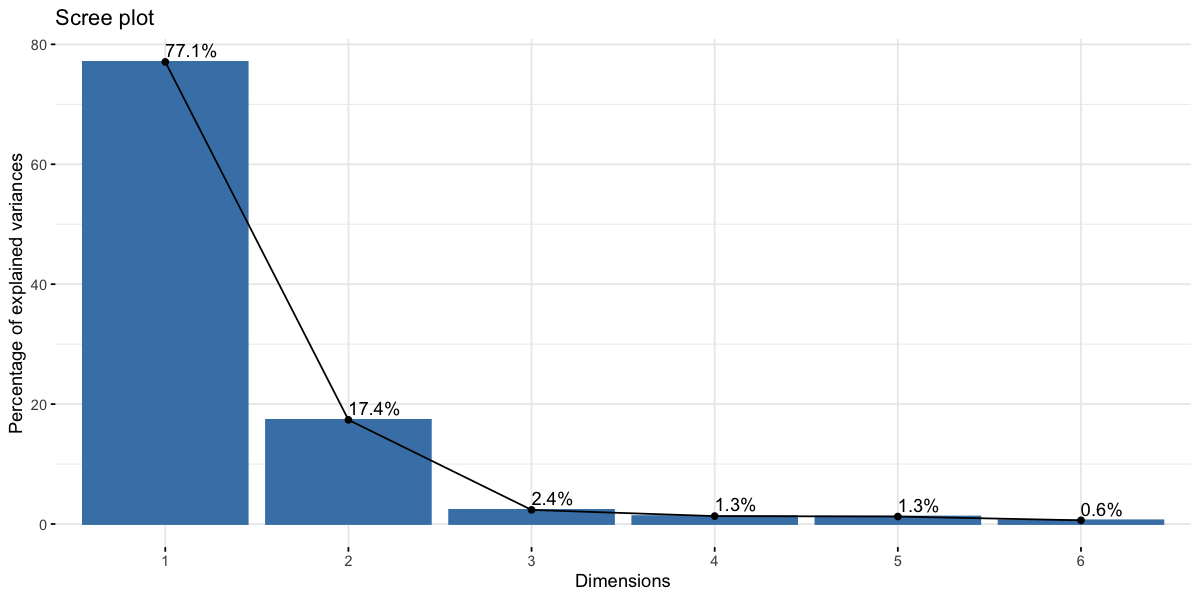

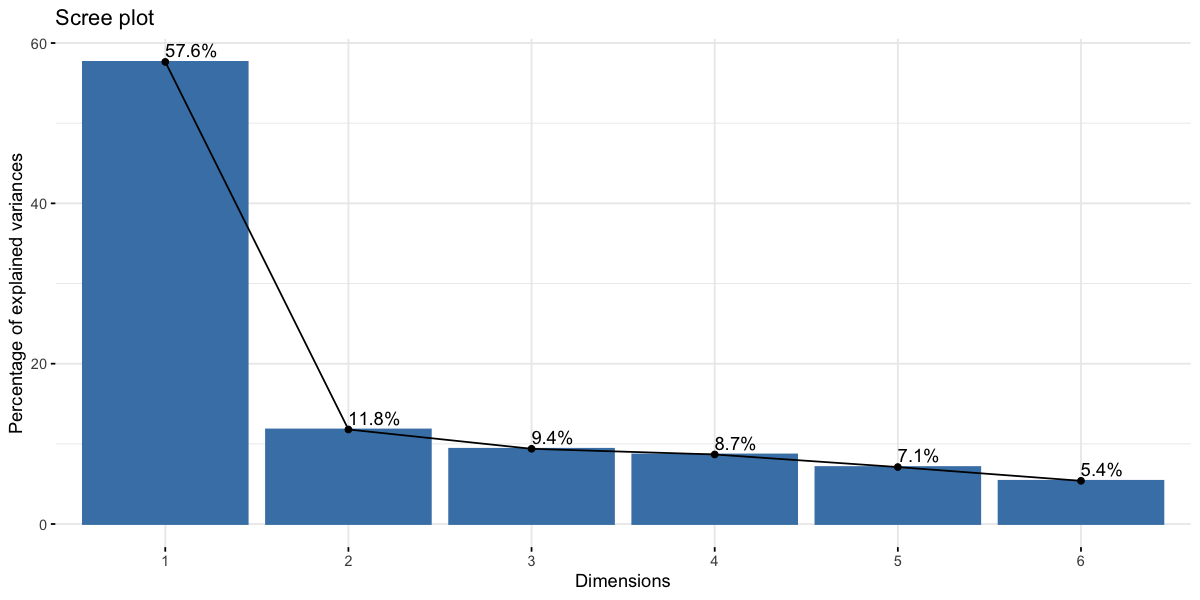

In [14]:
# running pca 
mRNA_pca = prcomp(wider_mRNA_df[,2:7], center = TRUE)#prcomp(wider_df[,2:7], center = TRUE)
protein_pca = prcomp(wider_proteomics_df[,2:7], center = TRUE)

# looking a scree plot to see how much of the variance was captured in first 2 eigenvectors
options(repr.plot.width = 10, repr.plot.height = 5) #changing size
fviz_eig(mRNA_pca, addlabels = TRUE)
fviz_eig(protein_pca, addlabels = TRUE)

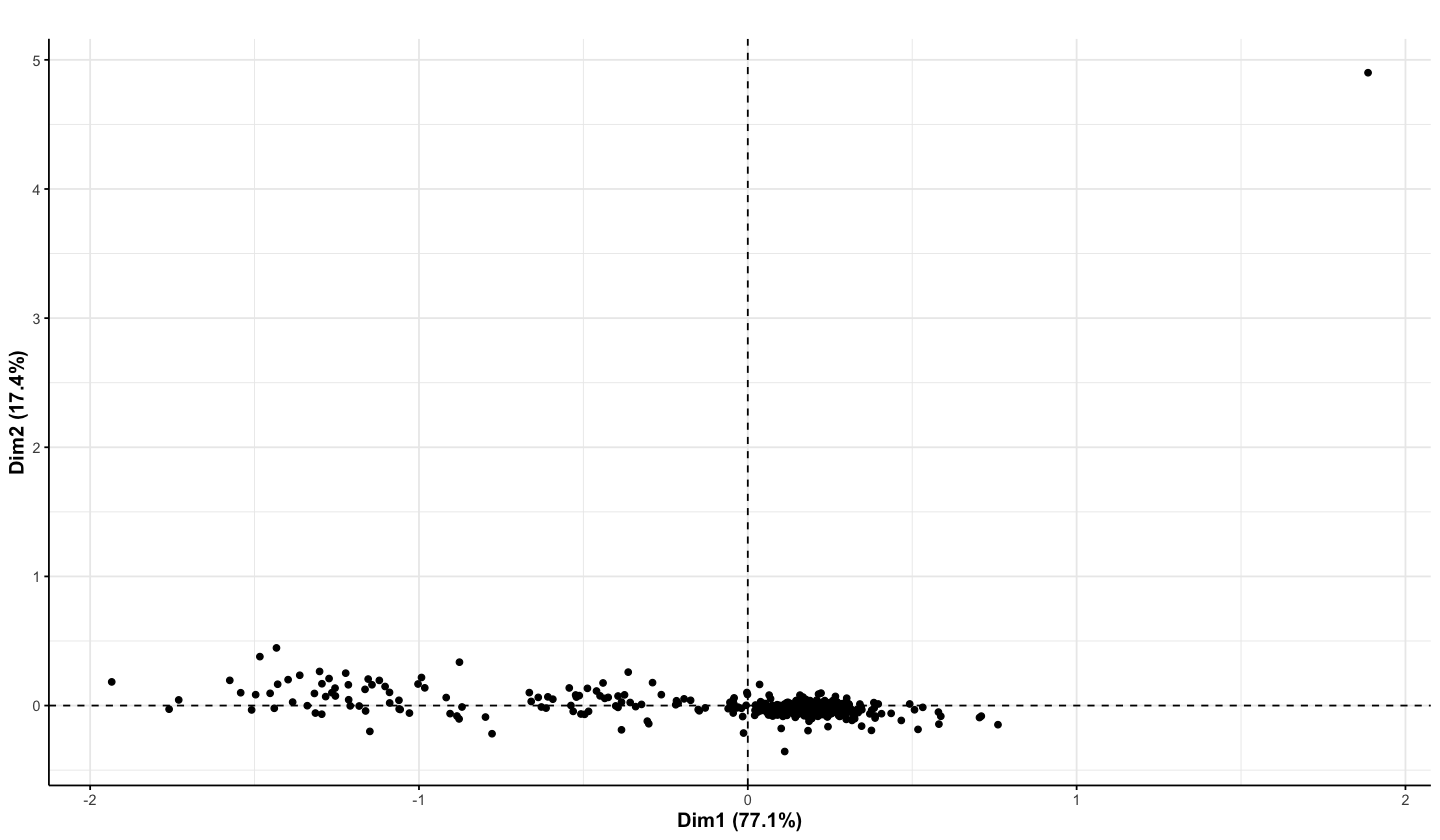

In [9]:
# # pca plot of all data together
# options(repr.plot.width = 12, repr.plot.height = 7) # changing size
# fviz_pca_ind(pca_all_data, geom.ind = "point", # removes geo ids
#              # coloring by biomarker
# #             col.ind = factor(as.character(wider_df$Biomarker)), 
# #              #adding 95% confidence ellipses for each group
# #              addEllipses = TRUE, # Concentration ellipses
# #              ellipse.type = "confidence", # now making them concentration ellipses
#              repel = TRUE, title = "") +
# theme(axis.line = element_line(colour = "black"), # making x and y axes black
#       legend.title = element_text(size = 9, face = "bold"),
#       legend.text = element_text(size = 8),
#       legend.position = 'bottom',
#       axis.title = element_text(face = "bold", size = rel(1.1))) # changes axis titles

In [15]:
# creating 1 df with eigenvectors, pslog2 values, condensate, burn condition data
mRNA_pca_df = data.frame(mRNA_pca$x[,1:2]) %>%
               rownames_to_column(var = "Sample_ID") 
more_data_biomarker_df =  rbind(wider_cytokine_df[,1:10] %>% 
               rename(Biomarker_Name = Cytokine), wider_mRNA_df[,1:10] %>% 
                rename(Biomarker_Name = mRNA), 
               wider_proteomics_df[,1:10] %>% 
                rename(Biomarker_Name = Protein_Accession)) %>%
               rownames_to_column(var = "Sample_ID")

mRNA_full_eigenvector_df = inner_join(mRNA_pca_df, more_data_biomarker_df)
head(mRNA_full_eigenvector_df)

Joining with `by = join_by(Sample_ID)`


,Sample_ID,PC1,PC2,Biomarker,F_1,M_2,M_3,F_4,F_5,M_6,Biomarker_Name,Condensate,Burn_Condition
,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,HMOX1_PBS_PBS_NA_24,0.05038454,-0.038354418,mRNA,4.774787,4.774766,4.774955,4.774918,4.774656,4.871886,HMOX1,PBS,PBS
2,ALDH3A1_PBS_PBS_NA_24,0.10600993,-0.007174593,mRNA,4.790564,4.815891,4.783329,4.821705,4.826226,4.837012,ALDH3A1,PBS,PBS
3,CXCL1_PBS_PBS_NA_24,0.17615156,-0.008220744,mRNA,4.802618,4.843155,4.883960,4.839909,4.855112,4.822372,CXCL1,PBS,PBS
4,GCLC_PBS_PBS_NA_24,0.22590368,-0.018814915,mRNA,4.851443,4.858772,4.865541,4.862229,4.871636,4.863186,GCLC,PBS,PBS
5,GCLM_PBS_PBS_NA_24,0.15591336,-0.015596145,mRNA,4.822743,4.829920,4.836289,4.837137,4.840402,4.834127,GCLM,PBS,PBS
6,GMCSF2_PBS_PBS_NA_24,-0.59289741,0.049360505,mRNA,4.582481,4.568797,4.562426,4.462491,4.525502,4.471997,GMCSF2,PBS,PBS


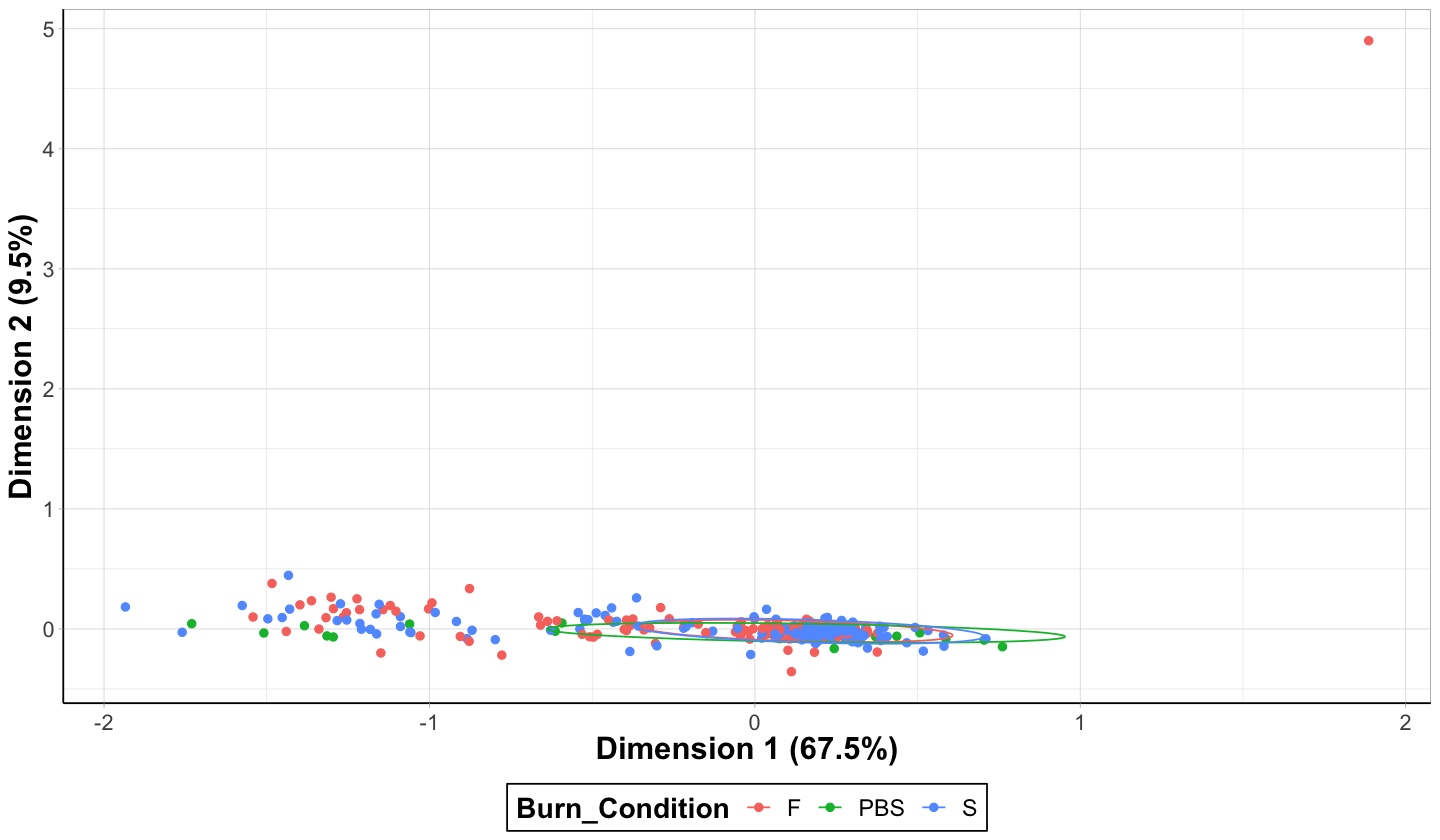

In [16]:
options(repr.plot.width=12, repr.plot.height=7) #changing size
ggplot(data = mRNA_full_eigenvector_df, aes(x = PC1, y = PC2, color = Burn_Condition)) + 
  geom_point(size = 2) + 
  stat_ellipse(level = 0.95) + # 95% confidence ellipses

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 17), #changes legend title
        legend.text = element_text(size = 14), #changes legend text
        legend.position = 'bottom',
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 
  xlab('Dimension 1 (67.5%)') + ylab('Dimension 2 (9.5%)')  #changing axis labels 

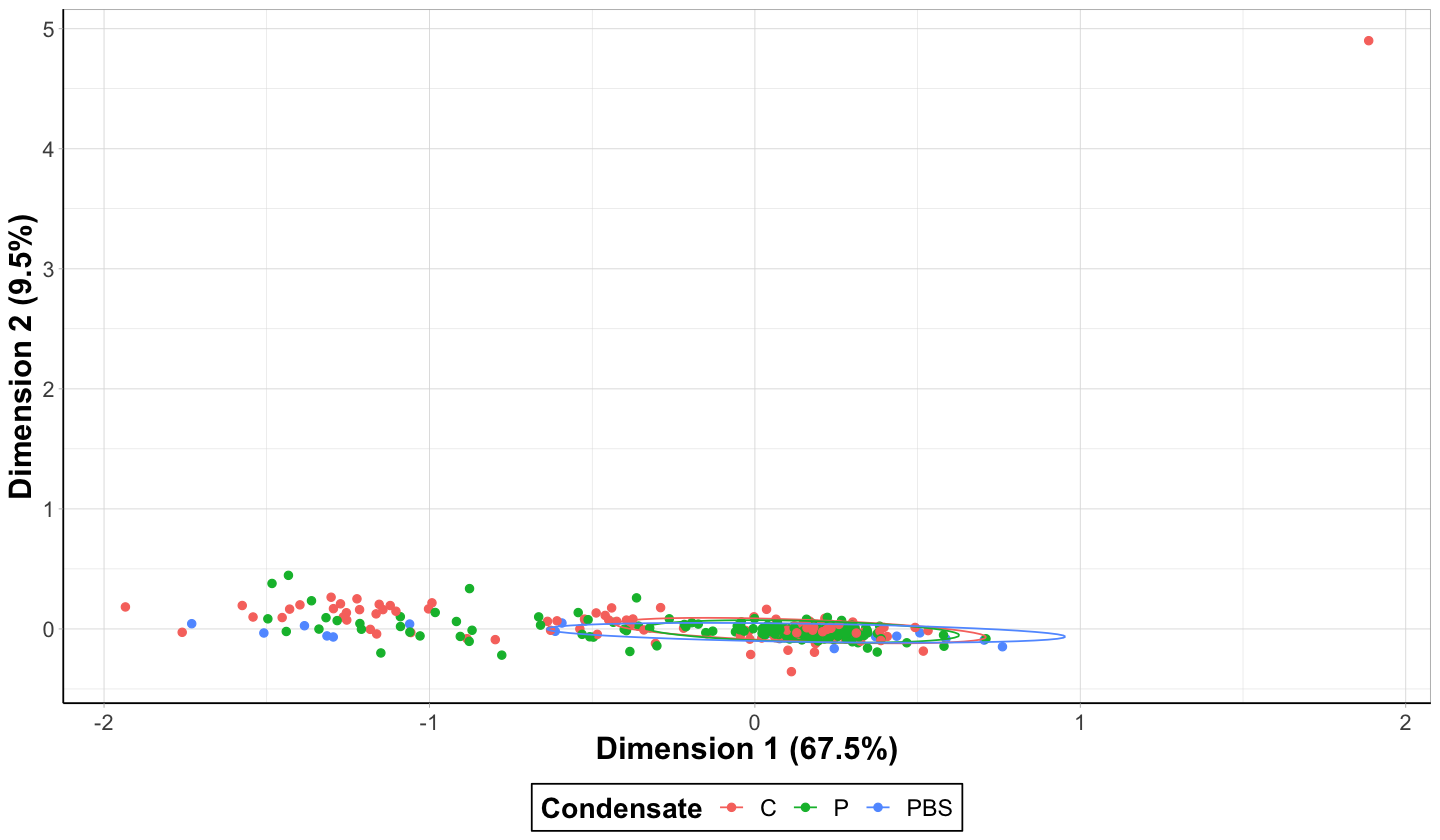

In [17]:
options(repr.plot.width=12, repr.plot.height=7) #changing size
ggplot(data = mRNA_full_eigenvector_df, aes(x = PC1, y = PC2, color = Condensate)) + 
  geom_point(size = 2) + 
  stat_ellipse(level = 0.95) + # 95% confidence ellipses

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 17), #changes legend title
        legend.text = element_text(size = 14), #changes legend text
        legend.position = 'bottom',
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 
  xlab('Dimension 1 (67.5%)') + ylab('Dimension 2 (9.5%)')  #changing axis labels 

The proteomics data looks the most promising, so let's just zoom in on that biomarker.

In [13]:
options(repr.plot.width=12, repr.plot.height=7) #changing size
condensate_plot = ggplot(data = full_eigenvector_df %>%
           filter(Biomarker == "Protein"), aes(x = PC1, y = PC2, color = Condensate)) + 
  geom_point(size = 2) + 
  stat_ellipse(level = 0.95) + # 95% confidence ellipses

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 17), #changes legend title
        legend.text = element_text(size = 14), #changes legend text
        legend.position = 'bottom',
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 
  xlab('Dimension 1 (67.5%)') + ylab('Dimension 2 (9.5%)')  #changing axis labels 

burn_condition_plot = ggplot(data = full_eigenvector_df %>%
           filter(Biomarker == "Protein"), aes(x = PC1, y = PC2, color = Burn_Condition)) + 
  geom_point(size = 2) + 
  stat_ellipse(level = 0.95) + # 95% confidence ellipses

  theme_light() + 
  theme(axis.text.x = element_text(vjust = 0.5), #rotating x labels/ moving x labels slightly to the left
        axis.line = element_line(colour="black"), #making x and y axes black
        axis.text = element_text(size = 13), #changing size of x axis labels
        axis.title = element_text(face = "bold", size = rel(1.7)), #changes axis titles
        legend.title = element_text(face = 'bold', size = 17), #changes legend title
        legend.text = element_text(size = 14), #changes legend text
        legend.position = 'bottom',
        legend.background = element_rect(colour = 'black', fill = 'white', linetype = 'solid'),
        strip.text.x = element_text(size = 18, face = "bold"), #changes size of facet x axis 
        strip.text.y = element_text(size = 18, face = "bold")) + #changes size of facet y axis 
  xlab('Dimension 1 (67.5%)') + ylab('Dimension 2 (9.5%)')  #changing axis labels 

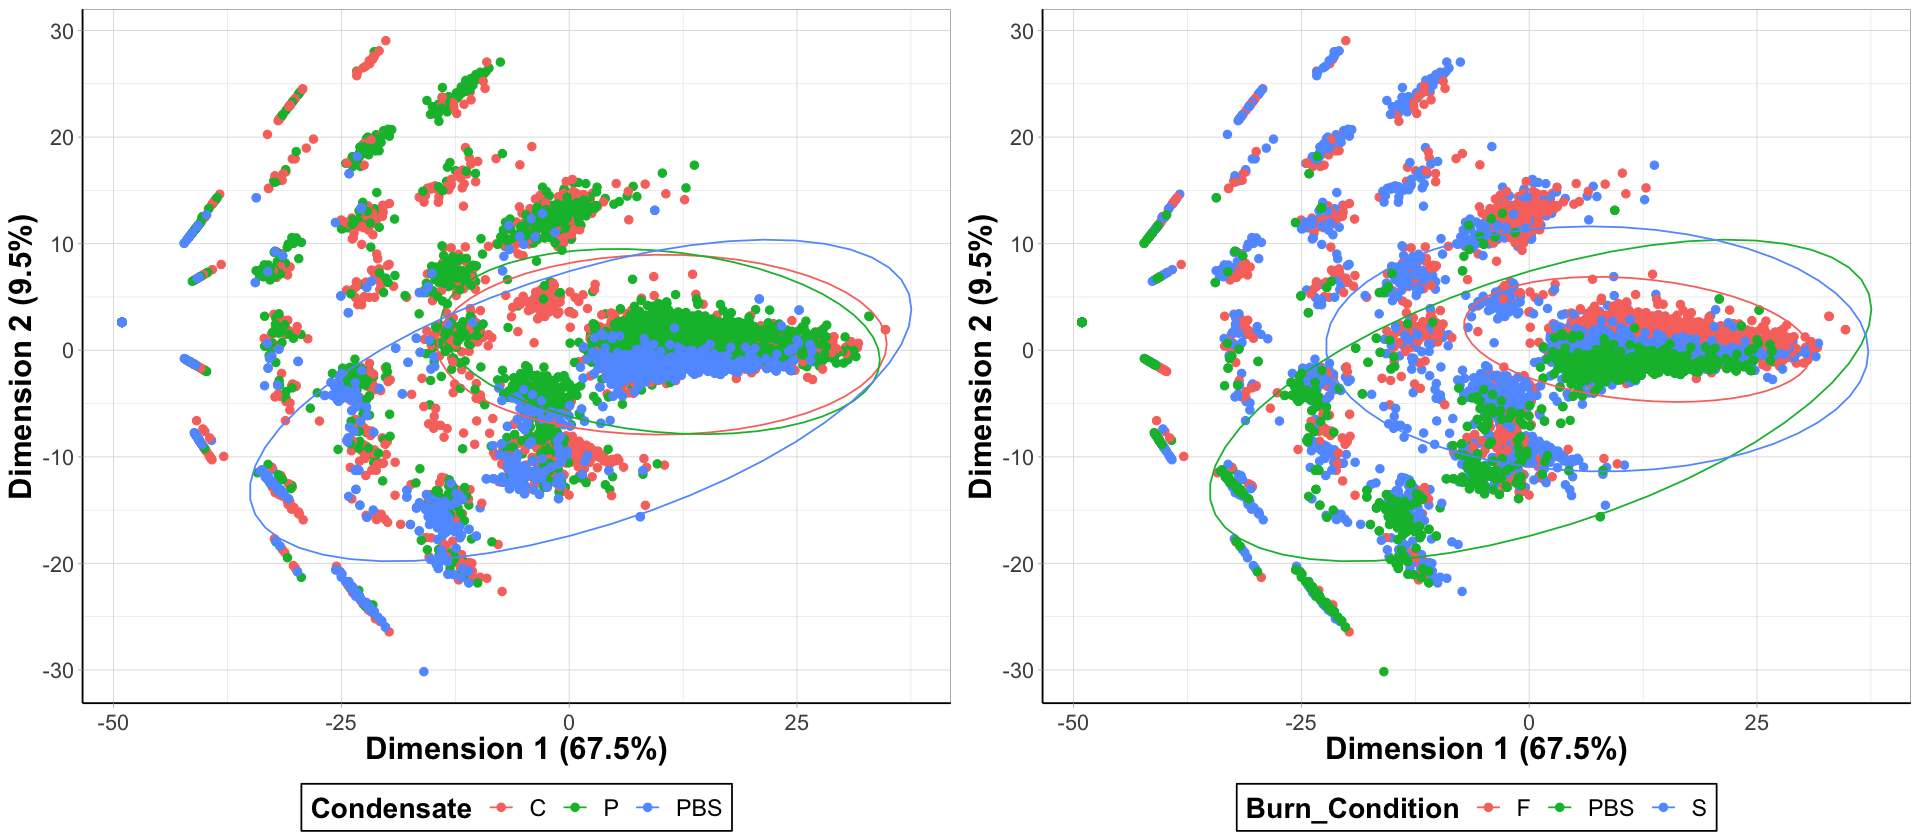

In [14]:
options(repr.plot.width = 16, repr.plot.height = 7) #changing size
plot_grid(condensate_plot, burn_condition_plot)